# Metadata annotation

Publically availble metadata can help contexualize an in-house experiment. Pertpy allows metadata to be easily fetched and perturbations to be annotated, augmenting existing datasets to increase sample sizes for training of machine learning models and add prior knowledge.

A couple of databases can be queried, which we categorize by the type of metadata:
- Cell line metadata： 
    - Cancer Dependency Map (DepMap) at Broad
    - Genomics of Drug Sensitivity in Cancer (GDSC)
- Genomic datasets:
    - DepMap at Broad: Gene expression data
    - DepMap at Sanger: Gene expression and protein intensity values
- Cell line x perturbation interactions:
    - Genomics of Drug Sensitivity in Cancer (GDSC): Drug sensitivity

This notebook demonstrates how you can use pertpy metadata with two examples:

1. Sanity check of private data with publically available cell line expression profiles
2. Analysis of cell-line specific IC50-related genes using the GDSC database

In [1]:
import random
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import anndata as ad
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
%load_ext autoreload
%autoreload 2

Let's use the dataset from the original MIX-Seq paper ([McFarland et al., 2020](https://www.nature.com/articles/s41467-020-17440-w)), a scRNA-seq dataset of 99 cell lines and 13 different drugs. We subset it to 50000 cells to speed up the run time.

In [3]:
adata = pt.dt.mcfarland_2020()

In [4]:
adata

AnnData object with n_obs × n_vars = 182875 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [5]:
sc.pp.filter_genes(adata, min_cells=30)
sc.pp.subsample(adata, n_obs = 50000, random_state=42)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

## Cell line metadata

`annotate` uses DepMap IDs as identifiers and adds metadata columns to `.obs`.

Data is downloaded to the directory for cache files used by scanpy (Defaults to `cache`).

In [6]:
pt_metadata = pt.md.CellLine()

In [7]:
pt_metadata.annotate(adata, cell_line_information =["cell_line_name","age","primary_disease"])

AnnData object with n_obs × n_vars = 50000 × 25031
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'cell_line_name', 'age', 'primary_disease'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    uns: 'log1p'

Annotated metadata is saved as additional columns in `adata.obs`.

In [8]:
adata.obs.iloc[:, 36:]

,cell_line_name,age,primary_disease
TTATGCTAGTGATCGG,NCI-H1581,44,Lung Cancer
AGCGTCGTCTCGGACG,SNU-1105,61,Brain Cancer
TTGGGTACATTGCTTT,SK-MEL-3,42,Skin Cancer
TACTTGTTCAGCGACC,786-O,58,Kidney Cancer
CACAGTATCGGCTACG,COLO-680N,57,Esophageal Cancer
...,...,...,...
TGCCCTACATGAGCGA,KYSE-270,79,Esophageal Cancer
CTGATCCGTATGTCAC,BT-474,60,Breast Cancer
TATTACCAGCAGACTG,NCI-H460,NaN,Lung Cancer
TGTGGTATCTCCAGGG,SK-MEL-3,42,Skin Cancer


We can check the number of overlapping cell lines using `lookup`.

In [9]:
lookup = pt_metadata.lookup()
lookup.available_cell_lines(query_id_list=adata.obs.cell_line.unique(), reference_id="cell_line_name")

171 cell lines are not found in the metadata.

38 cell lines are found!

One question we might have after sequencing an in vitro experiment is "How similar are our expression profiles compared to the public database?" To answer this, we generate "pseudobulks" by aggregating counts to the cell-type level and then compare them with bulk RNA-seq data.

In [10]:
ps = pt.tl.PseudobulkSpace()
# Calculate the pseudobulks
pdata = ps.compute(adata, target_col="DepMap_ID", groups_col="perturbation")
# Extract the base line expression
base_line = pdata[pdata.obs.perturbation == 'control']
base_line.obs.index = base_line.obs.index.str.replace('_control', '')

/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/decoupler/utils_anndata.py:181: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cols = obs.groupby([sample_col, groups_col]).apply(lambda x: x.apply(lambda y: len(y.unique()) == 1)).all(0)
/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [11]:
lookup.available_bulk_rna(query_id_list=base_line.obs.DepMap_ID.unique(), cell_line_source='broad')

1 cell lines are not found in the metadata.

154 cell lines are found!

Further parameters can be checked using `look.up.bulk_rna.{cell_line_source}.default_parameter` where `cell_line_source` should be either broad or sanger.

In [12]:
lookup.bulk_rna.broad.default_parameter

{'query_id': 'DepMap_ID', 'cell_line_source': 'broad'}

We annotate bulk RNA expression data from the Broad Institute because it contains more overlapping cell lines with the McFarland dataset.

In [13]:
pt_metadata.annotate_bulk_rna(base_line, cell_line_source="broad", query_id="DepMap_ID")

To annotate bulk RNA data from Broad Institue,  `DepMap_ID` is used as default reference and query identifier if no
`reference_id` is given.  Ensure that `DepMap_ID` is available in 'adata.obs'.  Alternatively, use `annotate()` to 
annotate the cell line first

[bold blue]There are 155 identifiers in `adata.obs`.However, 1 identifiers can't be found in the bulk RNA annotation,leading to the presence of NA values for their respective metadata.

- Please check again: 
- ACH-000047
- ...


/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/pertpy/metadata/_cell_line.py:395: ImplicitModificationWarning: Setting element `.obsm['bulk_rna_broad']` of view, initializing view as actual.
  adata.obsm["bulk_rna_broad"] = ccle_expression


AnnData object with n_obs × n_vars = 155 × 25031
    obs: 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'cell_line_name', 'age', 'primary_disease', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    obsm: 'bulk_rna_broad'
    layers: 'psbulk_props'

The bulk RNA expression data is stored in `adata.obsm[bulk_rna_broad]`

In [14]:
base_line.obsm['bulk_rna_broad']

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
ACH-000012,5.158660,0.000000,6.132371,1.974529,3.779260,0.028569,2.746313,6.275380,4.322649,3.956057,...,0.028569,0.201634,0.367371,0.014355,0.310340,0.584963,5.694323,0.000000,0.0,0.124328
ACH-000014,2.965323,0.000000,7.575388,2.378512,3.638074,0.056584,0.263034,6.349967,4.292045,4.081510,...,0.000000,0.594549,0.000000,0.124328,0.137504,0.555816,4.822730,0.042644,0.0,0.000000
ACH-000015,4.179511,0.000000,6.990161,2.950468,3.697107,0.014355,3.548437,6.184875,4.370164,4.319762,...,0.056584,0.263034,0.263034,0.014355,0.028569,0.545968,4.220330,0.000000,0.0,0.000000
ACH-000021,4.207893,0.000000,6.613826,2.419539,4.519164,0.000000,2.130931,6.100557,4.445594,4.148934,...,0.000000,0.443607,0.000000,0.042644,0.238787,1.049631,2.946731,0.124328,0.0,0.000000
ACH-000022,3.526069,0.000000,6.454176,2.733354,3.039138,0.014355,0.097611,5.821710,5.390599,4.448240,...,0.000000,0.000000,0.084064,0.070389,1.000000,0.250962,3.060047,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000977,2.811471,0.000000,5.916238,2.448901,2.847997,0.014355,0.070389,4.509062,4.197708,4.154616,...,0.000000,0.250962,0.000000,0.000000,0.214125,0.454176,4.452859,0.000000,0.0,0.000000
ACH-000982,5.168722,0.704872,6.223036,2.298658,4.175525,0.070389,0.056584,5.950702,5.679199,4.473787,...,0.056584,0.226509,0.400538,0.124328,0.400538,0.526069,2.965323,0.344828,0.0,0.111031
ACH-000997,3.912650,0.000000,6.841973,2.253989,4.562548,0.000000,0.056584,7.290388,4.680324,4.558880,...,0.000000,0.000000,0.070389,0.014355,0.378512,0.163499,4.303781,0.111031,0.0,0.042644
ACH-001190,4.001802,0.056584,7.097295,2.718088,4.610582,0.028569,2.490570,5.967860,4.426265,3.759156,...,0.111031,0.310340,0.454176,0.111031,0.286881,0.594549,2.684819,0.454176,0.0,0.000000


In [15]:
# Subset and sort overlapping genes
overlapping_genes = set(base_line.var.ensembl_id) & set(base_line.obsm['bulk_rna_broad'].columns)
base_line = base_line[:, base_line.var['ensembl_id'].isin(overlapping_genes)]
base_line.obsm['bulk_rna_broad'] = base_line.obsm['bulk_rna_broad'][base_line.var.ensembl_id]

/var/folders/zz/rylc5nzn5bzd41ydv9q1q7tm0000gn/T/ipykernel_36386/4254373752.py:4: ImplicitModificationWarning: Setting element `.obsm['bulk_rna_broad']` of view, initializing view as actual.
  base_line.obsm['bulk_rna_broad'] = base_line.obsm['bulk_rna_broad'][base_line.var.ensembl_id]


In [16]:
# Correlate the pseudobulks with the bulk RNA-seq data
# corr and pvals: correlation and p-value df for the overlapping cell lines
# new_corr and new_pvals: correlation and p-value df for cell lines that are only present in McFarland dataset
corr, pvals, new_corr, new_pvals = pt_metadata.correlate(base_line, identifier="DepMap_ID", metadata_key = "bulk_rna_broad")

The column name of metadata is not the same as the index of adata.var, please make sure the genes are in the same 
order.

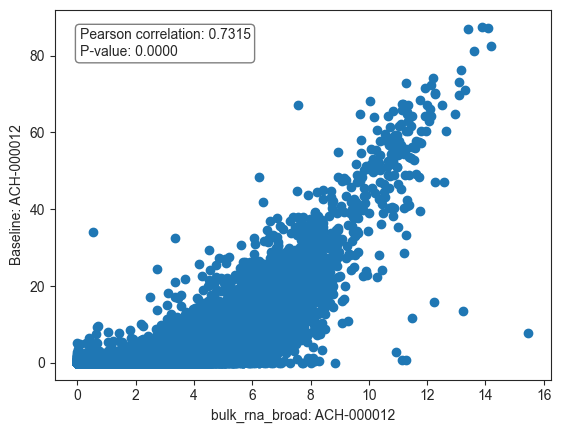

In [17]:
# Visualize the correlation of cell lines by scatter plot
pt.pl.md.plot_correlation(base_line, corr = corr, pval = pvals, 
                          identifier="DepMap_ID", metadata_key = "bulk_rna_broad",
                          subset_identifier = 0) # 0 means the first ids

We observe a high correlation between the baseline gene expression in the McFarland dataset and the bulk RNA-seq expression data from the Broad Institute, suggesting good concordance between these two sources. We can also visualize the correlation matrix via heatmap.

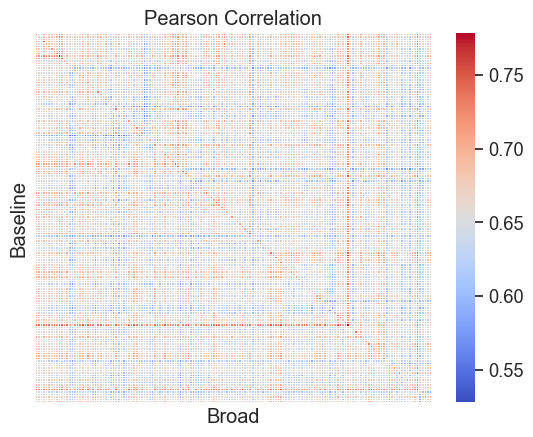

In [18]:
# Generally a cell line is most correlated with itself
sns.set(font_scale=1.2)
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths=.7, xticklabels=False, yticklabels=False)
plt.title('Pearson Correlation')
plt.xlabel('Broad')
plt.ylabel('Baseline')
plt.show()

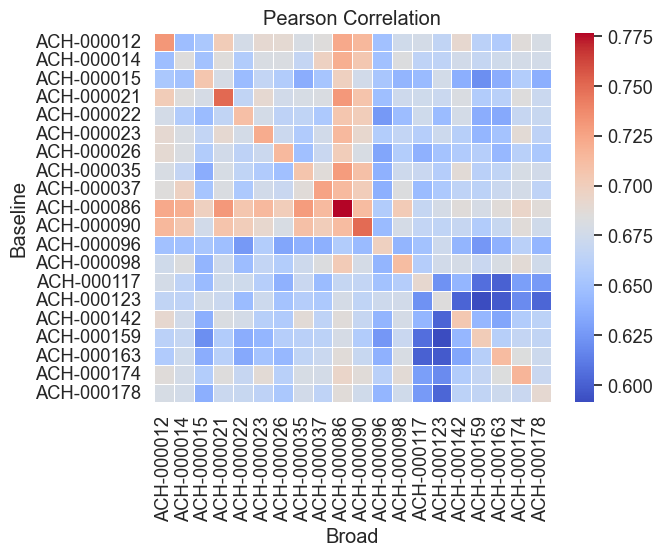

In [19]:
# Subset to first 20 cell lines
sns.heatmap(corr.iloc[:20,:20], cmap='coolwarm', annot=False, linewidths=.7, yticklabels=True)
plt.title('Pearson Correlation')
plt.xlabel('Broad')
plt.ylabel('Baseline')
plt.show()

The cell line that is not found in the broad database matches with the closest tissue type.

In [20]:
new_cl_max_corr = pd.concat([new_corr.idxmax(axis=1), new_corr.max(axis=1)], axis=1, keys=['cell_line', 'correlation'])
new_cl_max_corr

,cell_line,correlation
DepMap_ID,,
ACH-000047,ACH-000842,0.735263


In [21]:
base_line[base_line.obs['DepMap_ID'].isin(["ACH-000047", "ACH-000842"])].obs['singlet_ID']

ACH-000047             GCIY_STOMACH
ACH-000842    SW480_LARGE_INTESTINE
Name: singlet_ID, dtype: object

## IC50-related genes using the GDSC database

Post-treatment differential expression data can offer valuable insights into understanding the relationship between gene expression and drug responses. To demonstrate how pertpy can be used to model perturbation responses, a linear regression model can be trained to associate the single-cell transcriptional profiles measured in each cell line to their viability effects in the drug sensitivity data from GDSC. 

Cell line-specific drug sensitivity data can be retrieved from the GDSC database, which will be saved as a single column `ln_ic50` in `obs`.

In [22]:
pt_metadata.annotate_from_gdsc(pdata, query_id = "cell_line_name")

[bold blue]There are 193 identifiers in `adata.obs`.However, 87 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.

- Please check again: 
- SNU-1214
- YD-10B
- SNU-685
- SNU-1076
- SW579
- ...


AnnData object with n_obs × n_vars = 1109 × 25031
    obs: 'cell_line_name', 'perturbation', 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'age', 'primary_disease', 'psbulk_n_cells', 'psbulk_counts', 'ln_ic50'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    layers: 'psbulk_props'

In [23]:
pdata[~pdata.obs.ln_ic50.isna()].obs[['cell_line_name', 'perturbation', 'ln_ic50']]

,cell_line_name,perturbation,ln_ic50
index,,,
ACH-000023_Afatinib,PA-TU-8988T,Afatinib,1.471661
ACH-000035_Afatinib,NCI-H1650,Afatinib,0.901655
ACH-000098_Afatinib,GAMG,Afatinib,3.458473
ACH-000142_Afatinib,CAL-29,Afatinib,-0.580518
ACH-000149_Afatinib,SK-N-SH,Afatinib,1.696727
...,...,...,...
ACH-000950_Trametinib,LoVo,Trametinib,-2.944800
ACH-000958_Trametinib,SW48,Trametinib,-2.957706
ACH-000976_Trametinib,HuCCT1,Trametinib,-5.424971


In [24]:
# Subtract mean of the control from the perturbation, grouped by cell lines.
pdata.layers['counts'] = pdata.X.copy()
ps.compute_control_diff(pdata, target_col="perturbation", group_col="DepMap_ID", layer_key="counts")

AnnData object with n_obs × n_vars = 1109 × 25031
    obs: 'cell_line_name', 'perturbation', 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'age', 'primary_disease', 'psbulk_n_cells', 'psbulk_counts', 'ln_ic50'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    layers: 'psbulk_props', 'counts', 'control_diff'

In [25]:
# Remove the missing values
pdata = pdata[pdata.obs.perturbation != "control"]
pdata = pdata[~pdata.obs.ln_ic50.isna()]
pdata

View of AnnData object with n_obs × n_vars = 247 × 25031
    obs: 'cell_line_name', 'perturbation', 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'age', 'primary_disease', 'psbulk_n_cells', 'psbulk_counts', 'ln_ic50'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    layers: 'psbulk_props', 'counts', 'control_diff'

In [26]:
X_train, X_test, y_train, y_test = train_test_split(pdata.layers['control_diff'], pdata.obs.ln_ic50, 
                                                    test_size=0.1, random_state=2)
lr = LinearRegression() 
lr.fit(X_train, y_train)
y_predict= lr.predict(X_test)

In [27]:
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(random_state = 42)
# rf.fit(X_train, y_train)
# y_predict = rf.predict(X_test)

Mean squared error: 4.58
Coefficient of determination: 0.56


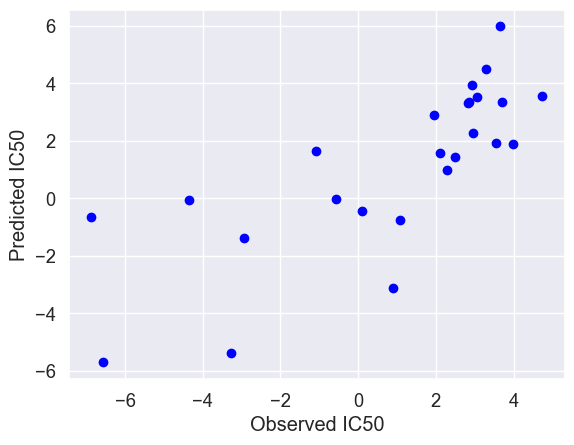

In [28]:
print(f"Mean squared error: {mean_squared_error(y_test, y_predict):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_predict):.2f}")
plt.scatter(y_test, y_predict, color="blue")
plt.xlabel("Observed IC50")
plt.ylabel("Predicted IC50")
plt.show()

The scatter plot shows the actual IC50 values along the x-axis and the IC50 values predicted by the linear regression model along the y-axis. For a good fit, all the points should be close to a diagonal line. However, this model has a low coefficient of determination, indicating that the regression model doesn't fit the test data very well. This might be caused by the "noise" in drug response data collected under various experimental conditions. This makes it challenging for the model to fit the majority of observed data well. Feature selection might improve the model performance since the dataset contains the 32738 genes.

We group the 99 McFarland cell lines with similar drug response across different perturbation conditions.

In [29]:
drug_response = pt_metadata.drug_response_gdsc1[pt_metadata.drug_response_gdsc1['cell_line_name'].isin(adata.obs.cell_line_name)].pivot(index='cell_line_name', columns='drug_name', values='ln_ic50')
drug_response

drug_name,(5Z)-7-Oxozeaenol,5-Fluorouracil,965-D2,993-D2,A-443654,A-770041,A-83-01,ACY-1215,AGI-6780,AICA Ribonucleotide,...,ZG-10,ZL049,ZL109,ZM447439,ZSTK474,Zibotentan,"eEF2K Inhibitor, A-484954",kb NB 142-70,rTRAIL,torin2
cell_line_name,,,,,,,,,,,,,,,,,,,,,
42-MG-BA,0.588826,2.220896,2.992956,4.755989,NaN,NaN,3.793761,2.390197,1.303087,7.562482,...,NaN,2.995327,-0.980930,1.339098,2.235509,5.494359,5.566457,3.082294,-1.651262,NaN
5637,1.626606,3.166983,4.410360,4.227483,NaN,NaN,3.847780,1.039981,1.127383,8.011505,...,NaN,2.053874,0.046212,0.556022,0.239659,5.144572,5.273391,2.519340,-2.889220,NaN
639-V,0.785227,4.210295,2.932099,4.028036,NaN,NaN,4.628202,2.099868,1.479390,7.448695,...,1.453090,4.385755,0.039382,1.779944,2.425340,5.144169,5.143294,1.978599,-2.467352,NaN
647-V,0.570678,3.228626,2.930507,3.106849,NaN,NaN,4.581358,1.754079,1.670076,7.547167,...,NaN,3.188942,-1.045608,3.044114,0.603523,5.756456,5.430844,2.733492,0.201503,NaN
769-P,0.612362,1.396611,3.010508,2.978909,NaN,NaN,3.855192,1.800764,1.943585,8.259149,...,NaN,3.162116,-0.425794,2.532378,-0.411142,5.441282,5.592060,1.830003,-0.026884,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TE-11,1.972644,4.283297,2.979829,3.598220,-2.093281,0.282573,4.005342,3.104331,1.730219,4.407174,...,NaN,3.992947,0.354113,0.406621,2.985028,5.396288,5.396288,3.860937,-0.753742,NaN
TE-6,5.312667,1.765484,5.250599,4.294427,-1.035718,2.397666,4.348313,0.522500,NaN,9.012906,...,NaN,3.040703,1.057910,3.795597,-0.236517,5.880011,5.693825,1.948988,0.353520,NaN
TE-8,-0.905723,2.297967,2.880687,3.359580,-1.749262,-1.274661,1.281641,0.520580,1.081485,6.899094,...,0.734422,2.860551,-0.444158,1.197542,1.441510,5.765258,5.138028,0.833960,0.221525,NaN


Before performing the clustering, we can impute the missing values in cell line sensitivity data with the mean IC50 value of this drug. Here we use `SimpleImputer` from sklearn package.

In [30]:
imputer = SimpleImputer(strategy='mean')
# Replace with the imputed values
drug_response[:] = imputer.fit_transform(drug_response.values)
# Create an drug x cell line anndata for drug response
adata_drug_reponse = ad.AnnData(drug_response)
adata_drug_reponse 

AnnData object with n_obs × n_vars = 116 × 378

/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


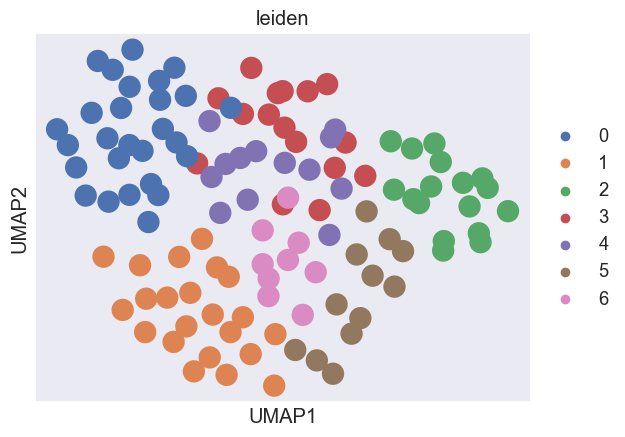

In [31]:
sc.pp.pca(adata_drug_reponse)
sc.pp.neighbors(adata_drug_reponse)
sc.tl.umap(adata_drug_reponse)
sc.tl.leiden(adata_drug_reponse, resolution = 1.5, key_added="leiden")
sc.pl.umap(adata_drug_reponse, color="leiden")

To visualize the clustering, cell lines are embedded into a UMAP embedding. The cell lines in the McFarland dataset are clustered into 7 groups in terms of gene–drug associations.

In [32]:
# Sort coefficients of the overlapping genes in decreasing order
coeff = pd.DataFrame({'coefficients': lr.coef_}, index=pdata.var_names).sort_values(by='coefficients', ascending=False)
coeff

,coefficients
IER3,0.006726
MIF,0.006518
CCND1,0.005616
HMGA1,0.005270
NEAT1,0.004915
...,...
TMEM256,-0.004298
NANS,-0.004542
TAX1BP3,-0.004630
TSC22D1,-0.004657


In [33]:
# Choose two sets of 3 cell lines randomly for visualisation
adata_drug_reponse.obs['cell_line_name'] = adata_drug_reponse.obs.index
cell_line_subset = adata_drug_reponse.obs.groupby('leiden').apply(lambda x: x.sample(3, random_state = 0)).reset_index(drop=True)
cell_line_subset = cell_line_subset[cell_line_subset.leiden.isin(['1','2'])].reset_index(drop=True)
cell_line_subset

/var/folders/zz/rylc5nzn5bzd41ydv9q1q7tm0000gn/T/ipykernel_36386/2454982798.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_line_subset = adata_drug_reponse.obs.groupby('leiden').apply(lambda x: x.sample(3, random_state = 0)).reset_index(drop=True)


,leiden,cell_line_name
0,1,TE-11
1,1,HT-1080
2,1,NCI-H460
3,2,BT-474
4,2,NCI-H1693
5,2,NCI-H2444


/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/homebrew/Caskroom/miniforge/base/envs/pertpy-env/lib/python3.10/site-packages/s

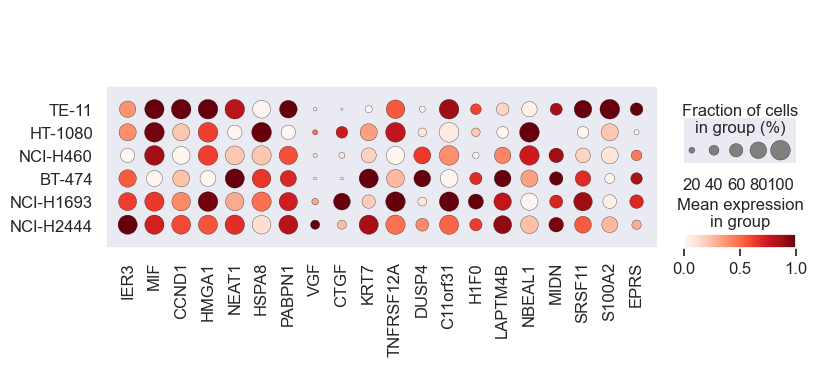

In [34]:
adata_subset = adata[adata.obs.cell_line_name.isin(cell_line_subset.cell_line_name.values)]
sc.pl.dotplot(adata_subset, var_names = coeff.index.values[0:20], 
              groupby = 'cell_line_name', standard_scale='var', 
              categories_order=cell_line_subset.cell_line_name)

We observe that the gene expression pattern is similar within each cell line set but vary across two sets. This implies that genes with high absolute coefficient values have a greater impact on drug response.